## ResFPN Classifier Tutorial - Flower Photos

by *Ming Ming Zhang*

In [1]:
import tensorflow as tf
print('TF Version:', tf.__version__)
#print('GPUs:', len(tf.config.list_physical_devices('GPU')))

import numpy as np
import matplotlib.pyplot as plt
import os, sys

TF Version: 2.3.1


In [2]:
# python files directory
PY_DIR = #'directory/to/python/files'
sys.path.append(PY_DIR)

# dataset directory
DATASET_DIR = #'directory/to/covidx'
sys.path.append(DATASET_DIR)

## Data Info

In [3]:
TRAIN_NUM_IMGS = {}

print('-----Training Set Info-----')
for class_name in os.listdir(DATASET_DIR):
    if class_name == 'LICENSE.txt':
        continue
    imgs_list = os.listdir(os.path.join(DATASET_DIR, class_name))
    num_imgs = len(imgs_list)
    TRAIN_NUM_IMGS[class_name] = num_imgs
    print('%s: %d images' % (class_name, num_imgs))

-----Training Set Info-----
daisy: 633 images
dandelion: 898 images
roses: 641 images
sunflowers: 699 images
tulips: 799 images


### TF Dataset

In [4]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE, 
    shuffle=True, 
    seed=123, 
    validation_split=0.1, 
    subset='training'
)

for x_train_batch, y_train_batch in train_ds.take(1):
    print(x_train_batch.shape, y_train_batch.shape)

Found 3670 files belonging to 5 classes.
Using 3303 files for training.
(32, 256, 256, 3) (32,)


In [6]:
CLASS_NAMES = train_ds.class_names
print('classes:', CLASS_NAMES)
NUM_CLASSES = len(CLASS_NAMES)

classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_DIR, 
    labels='inferred', 
    label_mode='int',
    class_names=None, 
    color_mode='rgb', 
    batch_size=BATCH_SIZE, 
    image_size=IMAGE_SIZE, 
    shuffle=True, 
    seed=123, 
    validation_split=0.1, 
    subset='validation'
)

for x_val_batch, y_val_batch in val_ds.take(1):
    print(x_val_batch.shape, y_val_batch.shape)

Found 3670 files belonging to 5 classes.
Using 367 files for validation.
(32, 256, 256, 3) (32,)


In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(1)
val_ds = val_ds.cache().prefetch(1)

#### Visualization

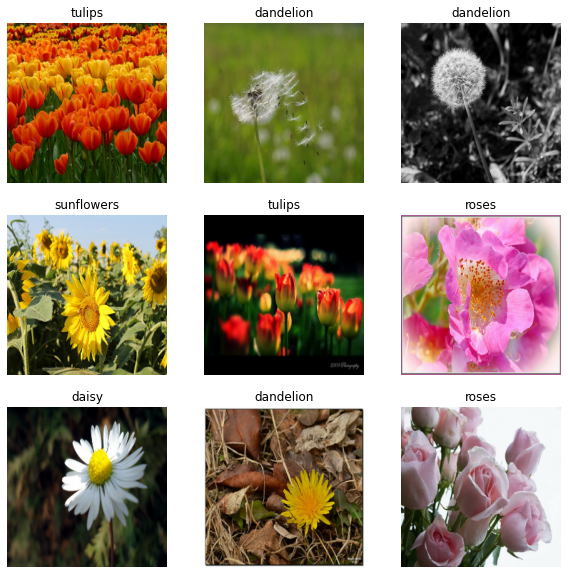

In [9]:
plt.figure(figsize=(10, 10))
for x_train_batch, y_train_batch in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(tf.cast(x_train_batch[i], tf.int32))
        plt.title(CLASS_NAMES[y_train_batch[i]])
        plt.axis('off')

### ResFPN Classifiers

In [10]:
import resnet, fpn, resnet_fpn

#### Without Pretrained ResNet Weights

In [11]:
ResFPN = resnet_fpn.ResFPN_Classifier(
    image_shape=IMAGE_SIZE + (3,), 
    num_classes=NUM_CLASSES, 
    num_filters=256, 
    architecture='resnet50', 
    augmentation=True,
    checkpoint_path=None,
    resnet_weights_path=None)

In [12]:
ResFPN.model.summary()

Model: "resnet50_fpn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_images (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 256, 256, 3)  0           input_images[0][0]               
__________________________________________________________________________________________________
random_rotation (RandomRotation (None, 256, 256, 3)  0           random_flip[0][0]                
__________________________________________________________________________________________________
random_zoom (RandomZoom)        (None, 256, 256, 3)  0           random_rotation[0][0]            
_______________________________________________________________________________________

In [13]:
ResFPN.train(
    train_dataset=train_ds, 
    val_dataset=val_ds, 
    epochs=5, 
    lr=0.001, 
    momentum=0.9, 
    l2=0.3, 
    save_weights=False)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
104/104 [==============================] - ETA: 0s - loss: 24.0154 - dense_resnet_loss: 1.4497 - dense_fpn_2_loss: 1.6547 - dense_fpn_3_loss: 1.7841 - dense_fpn_4_loss: 1.6527 - dense_fpn_5_loss: 1.5248 - dense_resnet_accuracy: 0.3854 - dense_fpn_2_accuracy: 0.3878 - dense_fpn_3_accuracy: 0.3751 - dense_fpn_4_accuracy: 0.3751 - dense_fpn_5_accuracy: 0.3857WARNING:te

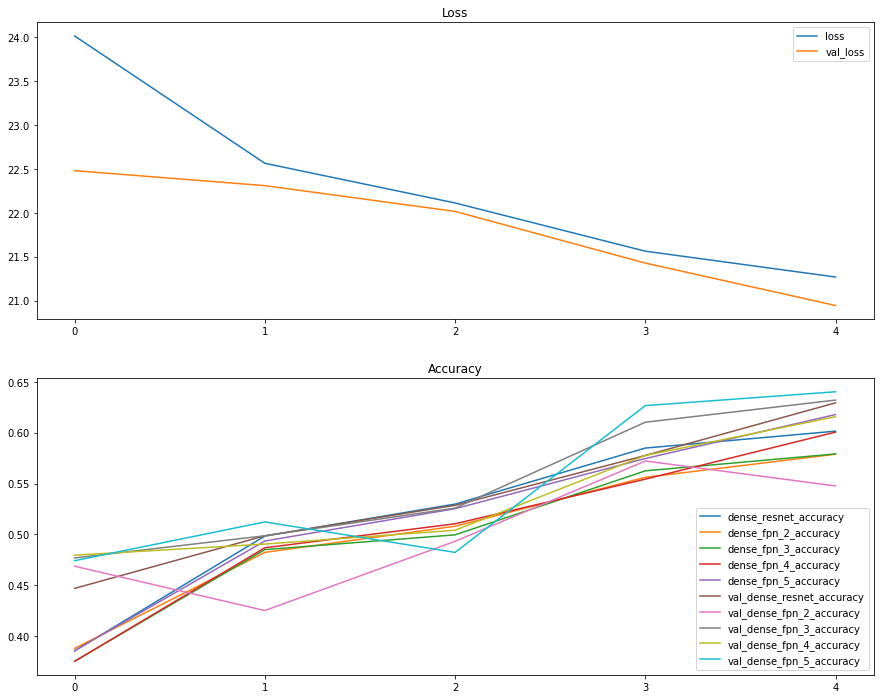

In [14]:
ResFPN.plot()

In [15]:
top_idxes, ensemble_acc = ResFPN.select_top(val_ds, top=3)

12/12 [==============================] - 1s 93ms/step - loss: 20.9447 - dense_resnet_loss: 0.9546 - dense_fpn_2_loss: 1.1292 - dense_fpn_3_loss: 0.9879 - dense_fpn_4_loss: 1.0058 - dense_fpn_5_loss: 0.9178 - dense_resnet_accuracy: 0.6294 - dense_fpn_2_accuracy: 0.5477 - dense_fpn_3_accuracy: 0.6322 - dense_fpn_4_accuracy: 0.6158 - dense_fpn_5_accuracy: 0.6403
Top classifiers: ['res_fpn_4', 'res_fpn_2', 'res_fpn_3']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @

In [16]:
ensemble_class_ids, metrics = ResFPN.predict(
    val_ds, CLASS_NAMES, display_metrics=True)

Test accuracy: 0.61

daisy:
  precision 0.88, recall 0.21, F1-score 0.33
dandelion:
  precision 0.73, recall 0.30, F1-score 0.42
roses:
  precision 0.39, recall 0.30, F1-score 0.33
sunflowers:
  precision 0.70, recall 0.40, F1-score 0.51
tulips:
  precision 0.56, recall 0.24, F1-score 0.32

Average:
  precision 0.65, recall 0.29, F1-score 0.38


#### With Pretrained ResNet Weights

In [17]:
filepath = #'path\to\pretrained_resnet_weights.h5'

In [18]:
pretrain_ResFPN = resnet_fpn.ResFPN_Classifier(
    image_shape=IMAGE_SIZE + (3,), 
    num_classes=NUM_CLASSES, 
    num_filters=256, 
    architecture='resnet50', 
    augmentation=True,
    checkpoint_path=None,
    resnet_weights_path=filepath)

In [19]:
pretrain_ResFPN.train(
    train_dataset=train_ds, 
    val_dataset=val_ds, 
    epochs=5, 
    lr=1e-3, 
    momentum=0.9, 
    l2=0.3, 
    save_weights=False)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
104/104 [==============================] - ETA: 0s - loss: 25.7826 - dense_resnet_loss: 1.4654 - dense_fpn_2_loss: 1.8688 - dense_fpn_3_loss: 1.7557 - dense_fpn_4_loss: 1.6229 - dense_fpn_5_loss: 1.5121 - dense_resnet_accuracy: 0.3899 - dense_fpn_2_accuracy: 0.4120 - dense_fpn_3_accuracy: 0.4193 - dense_fpn_4_accuracy: 0.3896 - dense_fpn_5_accuracy: 0.3987WARNING:te

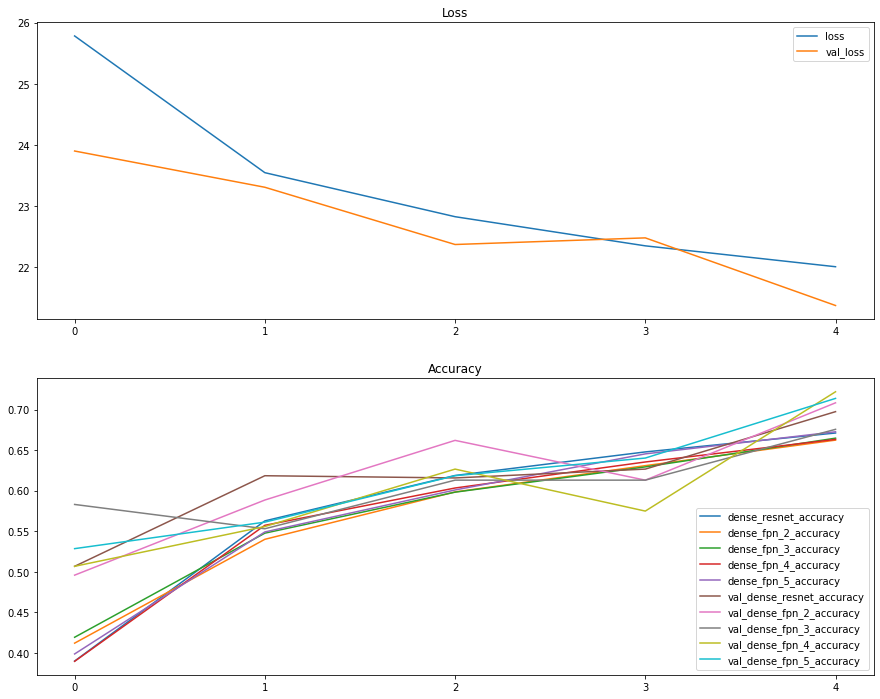

In [20]:
pretrain_ResFPN.plot()

In [21]:
top_idxes, val_acc = pretrain_ResFPN.select_top(val_ds, top=3)

12/12 [==============================] - 1s 93ms/step - loss: 21.3784 - dense_resnet_loss: 0.7690 - dense_fpn_2_loss: 0.7967 - dense_fpn_3_loss: 0.8059 - dense_fpn_4_loss: 0.7241 - dense_fpn_5_loss: 0.7249 - dense_resnet_accuracy: 0.6975 - dense_fpn_2_accuracy: 0.7084 - dense_fpn_3_accuracy: 0.6757 - dense_fpn_4_accuracy: 0.7221 - dense_fpn_5_accuracy: 0.7139
Top classifiers: ['res_fpn_3', 'res_fpn_4', 'resnet']
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.

In [22]:
ensemble_class_ids, metrics = pretrain_ResFPN.predict(
    val_ds, CLASS_NAMES, display_metrics=True)

Test accuracy: 0.70

daisy:
  precision 0.78, recall 0.36, F1-score 0.47
dandelion:
  precision 0.73, recall 0.44, F1-score 0.54
roses:
  precision 0.48, recall 0.19, F1-score 0.26
sunflowers:
  precision 0.90, recall 0.39, F1-score 0.54
tulips:
  precision 0.57, recall 0.49, F1-score 0.51

Average:
  precision 0.69, recall 0.37, F1-score 0.46
